In [9]:
import networkx as nx
import community
from community import community_louvain
import numpy as np
import copy  
import matplotlib.pyplot as plt
import collections
import graph_ase_BNU
from sklearn.utils.extmath import randomized_svd
import collections

In [295]:
def ase_graph(G): 
    sorted_vertex = sorted(G.nodes())
    A = nx.to_scipy_sparse_matrix(G, nodelist=sorted_vertex)
    n = G.number_of_nodes()
    max_dim = max_dim_ase
    
    svd_seed = 1234
    U, Sigma, VT = randomized_svd(A, 
                              n_components=min(max_dim, n - 1),
                              n_iter=50,
                              random_state=svd_seed)

    ##print ("dimension reduction (elbow selection)")
    #rank_graph =  getElbows_BNU.getElbows(Sigma, n_elbows=elb)
    
    #reduced_dim = rank_graph[(elb-1)]
    ##print ("elbow is %d" %reduced_dim)

    reduced_dim = 2 
    s_sqrt = np.sqrt(Sigma) 

    
    s_sqrt_dim_reduced = s_sqrt[:reduced_dim]
    U_dim_reduced = U[:, :reduced_dim ]
    VT_dim_reduced =VT[:reduced_dim, :]

    Xhat = np.multiply( s_sqrt_dim_reduced, U_dim_reduced)
    
    embedded_dict = {}
    for _, vertex in enumerate(sorted_vertex):
        embedded_dict[vertex] = Xhat[_, :]
     
    
    embedded = collections.namedtuple('embedded', 'Xhat vertex_labels dict')
    result = embedded(Xhat = Xhat, vertex_labels = sorted_vertex, dict = embedded_dict)
    
    return result

def sqdist(vector):
    return sum(x*x for x in vector)

def degtrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_minmax(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    if ctr <= count_threshold:
        high_trim = sorted_degrees_desc[ctr][0]
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(high_trim)
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

#procrustes
def procrustes(A, B):
    tmp = A.T @ B
    U_tmp, Sigma_tmp, VT_tmp = np.linalg.svd(tmp)
    W = U_tmp @ VT_tmp
    return W
    #A@W - B

In [2]:
file_108 = r'/Users/z/Desktop/execs_email_t108.txt'
file_109 = r'/Users/z/Desktop/execs_email_t109.txt'


In [115]:
G108 = nx.read_weighted_edgelist(file_108, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')
G109 = nx.read_weighted_edgelist(file_109, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')


In [116]:
print(G108.size())
print(G108.number_of_nodes())
print(G109.size())
print(G109.number_of_nodes())

136
88
166
98


In [174]:
G109_misses = set(G108.nodes()) - set(G109.nodes())
G108_misses = set(G109.nodes()) - set(G108.nodes())


In [118]:
# G108_world =  G_108
# G108_world.add_nodes_from(G_109)
# G109_world =  G_109
# G109_world.add_nodes_from(G_108)


In [119]:
# print(G108.size())
# print(G108.number_of_nodes())
# print(G109.size())
# print(G109.number_of_nodes())
# print(G108_world.size())
# print(G108_world.number_of_nodes())
# print(G109_world.size())
# print(G109_world.number_of_nodes())

136
88
166
98
136
106
166
106


In [ ]:
Graph = copy.deepcopy(G_108)
louvain_108 = community.best_partition(Graph, resolution=1, randomize=False)
mod_108 = community.modularity(louvain_108, Graph)
print(mod_108)

Graph = copy.deepcopy(G_109)
louvain_109 = community.best_partition(Graph, resolution=1, randomize=False)
mod_109 = community.modularity(louvain_109, Graph)
print(mod_109)

In [177]:
max_deg = 9
Gtrim_mod = degtrim_max(G_109, max_deg)
G109_trimmed = Gtrim_mod.G
mod_109_trimmed = Gtrim_mod.mod
print (mod_109_trimmed)

0.8660762574364523


In [191]:
print(set(G109.nodes()) - set(G109_trimmed.nodes()))
print(G108_misses)
#note here trimming only trimmed nodes that were common in both G108 and G109
#remember to do procrustes!!!!! 

intersecting_108_109 =   set(G108.nodes()).intersection(set(G109.nodes()))
intersecting_all3 =   list(set(intersecting_108_109).intersection(set(G109_trimmed.nodes())))

print(len(intersecting_108_109))
print(len(intersecting_all3))

{'169', '114', '107', '82', '65', '63', '58', '128', '140'}
{'76', '16', '139', '48', '175', '49', '132', '62', '116', '93', '70', '53', '18', '157', '98', '109', '59', '81'}
80
71


In [225]:
#list(intersecting_108_109 )

In [184]:
ase_G108 = ase_graph(G108)
ase_G109 = ase_graph(G109)
ase_G109_trimmed = ase_graph(G109_trimmed)


In [236]:

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_G108.vertex_labels.index(v))
Xhat108_shared = ase_G108.Xhat[intersecting_index]

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_G109.vertex_labels.index(v))
Xhat109_shared = ase_G109.Xhat[intersecting_index]

intersecting_index = []
for v in intersecting_all3:
    intersecting_index.append(ase_G109_trimmed.vertex_labels.index(v))
Xhat109_trimmed_shared = ase_G109_trimmed.Xhat[intersecting_index]

In [280]:
#procrustes
W_109_108 = procrustes(Xhat109_shared, Xhat108_shared)
Xhat109_shared_proj = Xhat109_shared@W_109_108 


W_109_trimmed_108 = procrustes(Xhat109_trimmed_shared, Xhat108_shared)
Xhat109_trimmed_shared_proj = Xhat109_trimmed_shared@W_109_trimmed_108 


In [281]:

Xhat_108_109 = Xhat108_shared - Xhat109_shared_proj 
diff_108_109 = np.linalg.norm(Xhat_108_109, axis=1)

In [282]:
diff_108_109

array([5.06164441e-01, 1.74891613e-01, 1.49816018e-01, 6.09137565e-01,
       3.16593769e-23, 9.66606663e-02, 9.89538550e-02, 4.34768254e-01,
       1.18864114e-01, 1.26807951e-01, 1.08387815e-01, 4.37778699e-03,
       6.38862400e-01, 1.45504900e-03, 1.08316172e-01, 2.64157582e-01,
       7.58333921e-02, 7.46891816e-02, 4.24906782e-02, 1.45764134e-01,
       1.19917249e-21, 1.18954206e-01, 5.86573060e-01, 7.42602835e-02,
       8.29796254e-03, 4.33035392e-02, 5.71193595e-01, 1.70269968e-23,
       5.11667452e-22, 1.78973998e-02, 1.36358446e-23, 4.88271339e-02,
       3.56709500e-01, 8.52708383e-44, 3.11303373e-01, 8.45866991e-02,
       5.11667452e-22, 9.12117845e-24, 1.14332635e-01, 1.36358444e-23,
       1.73162431e-01, 2.21566403e-02, 1.45457902e-02, 4.86362330e-03,
       1.98222899e-43, 2.84059851e-40, 7.08775644e-01, 1.85644131e-01,
       3.85548598e-03, 1.16860831e-01, 1.83171166e-39, 5.06601446e-02,
       1.62560602e-01, 3.82343999e-01, 2.51327010e-02, 1.05353270e-15,
      

In [283]:
Xhat_108_109_trimmed = Xhat108_shared - Xhat109_trimmed_shared_proj 
diff_108_109_trimmed = np.linalg.norm(Xhat_108_109_trimmed, axis=1)
diff_108_109_trimmed

array([6.30476416e-01, 6.69166103e-01, 9.84309485e-01, 6.62348825e-01,
       1.48230862e-16, 6.28899926e-01, 6.55234931e-55, 9.13281229e-01,
       6.41801057e-01, 1.79475563e-01, 6.53028685e-01, 4.73663412e-02,
       4.91100310e-01, 1.45504900e-03, 1.37773938e-01, 2.17838257e-01,
       1.95293105e-03, 8.51307428e-01, 1.37682649e-17, 7.85685929e-01,
       4.03369045e-16, 7.51983847e-02, 7.65131019e-01, 7.42602835e-02,
       8.29796254e-03, 7.15821374e-01, 6.96424583e-01, 5.42562633e-17,
       1.72164805e-16, 1.36770615e-01, 9.45945303e-18, 5.44613553e-02,
       1.01309347e+00, 1.22744326e-32, 3.80709470e-01, 3.56930380e-01,
       1.72164805e-16, 1.63837977e-17, 8.08156942e-02, 9.45918712e-18,
       1.09685428e-17, 1.05988857e-02, 2.68020420e-01, 5.09191261e-02,
       3.36660649e-33, 2.84059847e-40, 7.39343051e-01, 5.01774727e-18,
       2.03935875e-17, 4.09739435e-02, 1.83171166e-39, 7.65131019e-01,
       7.95211975e-01, 2.21649059e-01, 4.69618565e-17, 3.38318087e-16,
      

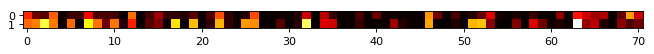

In [284]:
a = np.array(diff_108_109)
b = np.array(diff_108_109_trimmed)
m = np.vstack((a,b))
#m1 = np.asmatrix(m)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(m, cmap='hot', interpolation='nearest')
plt.show()
#black means small number

In [291]:
rank_trim = []
rank_noise = []

idx = 1 
for idx in range(Xhat108_shared.shape[0]):
    distance_to_noisy = Xhat109_shared_proj - Xhat108_shared[idx,]
    diff_Noise_108v = np.linalg.norm(distance_to_noisy, axis=1)
    distance_to_trim = Xhat109_trimmed_shared_proj - Xhat108_shared[idx,]
    diff_Trim_108v = np.linalg.norm(distance_to_trim, axis=1)
    rank_trim.append(diff_Trim_108v.argsort()[0]) 
    rank_noise.append(diff_Noise_108v.argsort()[0])
    
delta_rank = np.array(rank_noise) - np.array(rank_trim)

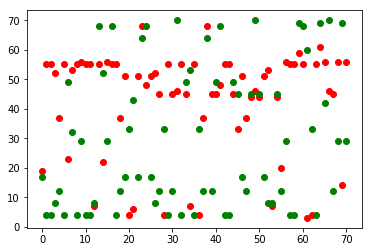

In [289]:
plt.plot(np.array(rank_noise), 'ro')
plt.plot(np.array(rank_trim), 'go')


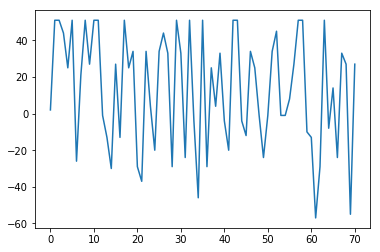

In [292]:
plt.plot(delta_rank)

In [293]:
delta_rank_original = delta_rank

In [294]:
delta_rank_original 

array([  2,  51,  51,  44,  25,  51, -26,  21,  51,  27,  51,  51,  -1,
       -13, -30,  27, -13,  51,  25,  34, -29, -37,  34,   4, -20,  34,
        44,  33, -29,  51,  33, -24,  51,  -4, -46,  51, -29,  25,   4,
        33,  -4, -20,  51,  51,  -4, -12,  34,  25,  -1, -24,  -1,  34,
        45,  -1,  -1,   8,  27,  51,  51, -10, -13, -57, -29,  51,  -8,
        14, -24,  33,  27, -55,  27])

(array([32., 14.,  7.,  3.,  5.,  2.,  2.,  1.,  3.,  2.]),
 array([8.52708383e-44, 7.25068649e-02, 1.45013730e-01, 2.17520595e-01,
        2.90027460e-01, 3.62534324e-01, 4.35041189e-01, 5.07548054e-01,
        5.80054919e-01, 6.52561784e-01, 7.25068649e-01]),
 <a list of 10 Patch objects>)

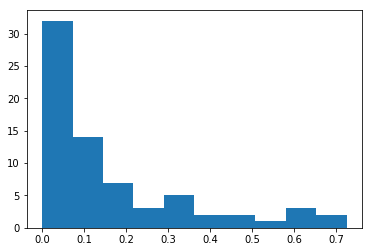

In [286]:
plt.hist(a)

(array([37.,  9.,  4.,  2.,  1.,  8.,  5.,  2.,  2.,  1.]),
 array([6.55234931e-55, 1.20652178e-01, 2.41304356e-01, 3.61956533e-01,
        4.82608711e-01, 6.03260889e-01, 7.23913067e-01, 8.44565245e-01,
        9.65217423e-01, 1.08586960e+00, 1.20652178e+00]),
 <a list of 10 Patch objects>)

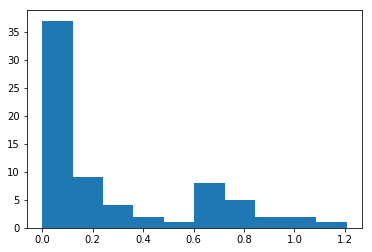

In [287]:
plt.hist(b)

In [143]:
ase_G108 = ase_graph(G108)
ase_G109 = ase_graph(G109)

#remember to do procrustes!!!!! 

intersecting_vertex- =   set(G108.nodes()).intersection(set(G109.nodes()))



G108_shared = ase_G108.Xhat[intersecting_vertex]
G109_shared = ase_G109.Xhat[intersecting_vertex]
  

if 1:
    reference = G108_shared[vertex]
    G109_difference = G109_shared - reference
    G109_


myListOfVectors.sort(key=sqdist)    
    reference = ase_G108.dict[vertex]
    Euc_distance = ase_G109


In [160]:
v = ['b', 'm', 'c', 'd']
m = np.array([2, 5.3, 0.8, 1.9])
m.argsort()
#myListOfVectors.sort(key=sqdist)  

array([2, 3, 0, 1])

In [153]:
m = [0, 1]


[m]

array([[ 2.33031915e-24, -9.81945445e-19],
       [ 9.43902461e-05, -2.22393978e-06]])

In [ ]:
#no lcc
G = G_109


print ("compute ase")
max_dim_ase = 2
#ASE = graph_ase_BNU.adjacency_embedding(G, max_dim=max_dim_ase, get_lcc=False, elb=1, svd_seed = 1234)

if 1: 
    max_dim = max_dim_ase
    elb = 1
    svd_seed = 1234
    U, Sigma, VT = randomized_svd(A, 
                              n_components=min(max_dim, n - 1),
                              n_iter=50,
                              random_state=svd_seed)

    ##print ("dimension reduction (elbow selection)")
    #rank_graph =  getElbows_BNU.getElbows(Sigma, n_elbows=elb)
    
    #reduced_dim = rank_graph[(elb-1)]
    ##print ("elbow is %d" %reduced_dim)

    reduced_dim = 2 
    s_sqrt = np.sqrt(Sigma) 

    
    s_sqrt_dim_reduced = s_sqrt[:reduced_dim]
    U_dim_reduced = U[:, :reduced_dim ]
    VT_dim_reduced =VT[:reduced_dim, :]

    Xhat_ase_109 = np.multiply( s_sqrt_dim_reduced, U_dim_reduced)
          



In [120]:
#no lcc
G = G_108
sorted_vertex = sorted(G.nodes())
A = nx.to_scipy_sparse_matrix(G, nodelist=sorted_vertex)
n = G.number_of_nodes()
max_dim_ase = 2



#ASE = graph_ase_BNU.adjacency_embedding(G, max_dim=max_dim_ase, get_lcc=False, elb=1, svd_seed = 1234)



compute ase


In [58]:
#no lcc
G = G108_world
sorted_vertex = sorted(G.nodes())
A = nx.to_scipy_sparse_matrix(G, nodelist=sorted_vertex)
n = G.number_of_nodes()

print ("compute ase")
max_dim_ase = 2
#ASE = graph_ase_BNU.adjacency_embedding(G, max_dim=max_dim_ase, get_lcc=False, elb=1, svd_seed = 1234)

if 1: 
    max_dim = max_dim_ase
    elb = 1
    svd_seed = 1234
    U, Sigma, VT = randomized_svd(A, 
                              n_components=min(max_dim, n - 1),
                              n_iter=50,
                              random_state=svd_seed)

    ##print ("dimension reduction (elbow selection)")
    #rank_graph =  getElbows_BNU.getElbows(Sigma, n_elbows=elb)
    
    #reduced_dim = rank_graph[(elb-1)]
    ##print ("elbow is %d" %reduced_dim)

    reduced_dim = 2 
    s_sqrt = np.sqrt(Sigma) 

    
    s_sqrt_dim_reduced = s_sqrt[:reduced_dim]
    U_dim_reduced = U[:, :reduced_dim ]
    VT_dim_reduced =VT[:reduced_dim, :]

    Xhat_ase_108_world = np.multiply( s_sqrt_dim_reduced, U_dim_reduced)

compute ase


In [60]:
Xhat_ase_108_world.shape

(106, 2)

In [61]:
Xhat_ase_108.shape

(106, 2)

In [17]:
A = Xhat_ase_108
B = Xhat_ase_109

In [21]:
#np.linalg.svd(A)
np.linalg.norm(A)

3.290838800485832

In [16]:
G = G_108
tot_degree_sequence_108 = [d for n, d in G.degree()]  # degree sequence

G = G_109
tot_degree_sequence_109 = [d for n, d in G.degree()]  # degree sequence


(0, 60)

<Figure size 432x288 with 0 Axes>

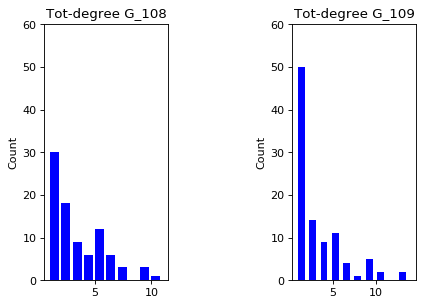

In [36]:
fig = plt.figure()
#fig.tight_layout()
plt.figure(figsize=(6, 4), dpi=80)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 1   # the amount of width reserved for blank space between subplots
hspace = 1   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)



plt.subplot(1, 2, 1)
plt.hist(tot_degree_sequence_108, width=0.80, color='b')
plt.title("Tot-degree G_108")
plt.ylabel("Count")
#plt.xlabel("Out Degree")
plt.ylim(0, 60)

plt.subplot(1, 2, 2)
plt.hist(tot_degree_sequence_109, width=0.80, color='b')
plt.title("Tot-degree G_109")
plt.ylabel("Count")
#plt.xlabel("In Degree")
plt.ylim(0, 60)

In [20]:
def degtrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_min(G, min_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] <= min_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

In [75]:

Graph = copy.deepcopy(G_108)
louvain_108 = community.best_partition(Graph, resolution=1, randomize=False)
mod_108 = community.modularity(louvain_108, Graph)
print(mod_108)




0.7797091262975778


In [76]:
Graph = copy.deepcopy(G_109)
louvain_109 = community.best_partition(Graph, resolution=1, randomize=False)
mod_109 = community.modularity(louvain_109, Graph)
print(mod_109)

0.6730294672666571


In [74]:
#G_raw = G_109
graphs_modularity1 = []
graphs_maxdeg = []
max_deg_list = [20, 15, 14, 13, 12, 11, 10, 9]

G_trimmed_new = G_109
for max_deg in max_deg_list:
    Gtrim_mod = degtrim_max(G_trimmed_new, max_deg)
    G_trimmed_new = Gtrim_mod.G
    graphs_maxdeg.append(max_deg)
    graphs_modularity1.append(Gtrim_mod.mod) 

print (graphs_modularity1)
print (graphs_maxdeg)

[0.6730294672666571, 0.6730294672666571, 0.7034496191135734, 0.7034496191135734, 0.7290880740405411, 0.7290880740405411, 0.7669309325450148, 0.8029211371289844]
[20, 15, 14, 13, 12, 11, 10, 9]


In [51]:
graphs_modularity2 = []
graphs_mindeg = []
min_deg_list = [1, 2, 3, 4, 5]
G_trimmed_new = G_109
for min_deg in min_deg_list:
    Gtrim_mod = degtrim_min(G_trimmed_new, min_deg)
    G_trimmed_new = Gtrim_mod.G
    graphs_mindeg.append(min_deg)
    graphs_modularity2.append(Gtrim_mod.mod) 

print (graphs_modularity2)
print (graphs_mindeg)

[0.5950363559882219, 0.525326797385621, 0.46474358974358976, 0.30898668639053256, 0.12326869806094183]
[1, 2, 3, 4, 5]


In [40]:
def degcentralitytrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)
    degree_centrality_dict = nx.degree_centrality(G)
    for vertex in degree_centrality_dict:
        if degree_centrality_dict[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degcentralitytrim_min(G, min_threshold):
    tmpG = copy.deepcopy(G)
    degree_centrality_dict = nx.degree_centrality(G)
    for vertex in degree_centrality_dict:
        if degree_centrality_dict[vertex] <= min_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

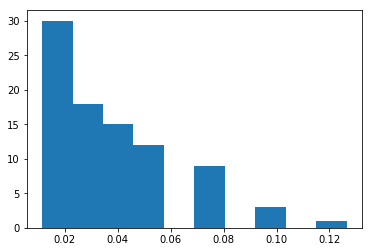

In [41]:
deg_centrality_dict = nx.degree_centrality(G_raw)

degree_centrality_list = []
for vertex in deg_centrality_dict:
    degree_centrality_list.append(deg_centrality_dict[vertex])



plt.hist(degree_centrality_list)
plt.show()

In [49]:
graphs_modularity3 = []
graphs_maxdegcentrality = []
max_degcentrality_list = [0.14, 0.12, 0.10, 0.08, 0.06, 0.04]

G_trimmed_new = G_109
for max_degcentrality in max_degcentrality_list:
    Gtrim_mod = degcentralitytrim_max(G_trimmed_new, max_degcentrality)
    G_trimmed_new = Gtrim_mod.G
    graphs_maxdegcentrality.append(max_degcentrality)
    graphs_modularity3.append(Gtrim_mod.mod) 

print (graphs_modularity3)
print (graphs_maxdegcentrality)

[0.7034496191135734, 0.7290880740405411, 0.7669309325450148, 0.8427217825905874, 0.9073777777777778, 0.9130752373995615]
[0.14, 0.12, 0.1, 0.08, 0.06, 0.04]


In [50]:
graphs_modularity4 = []
graphs_mindegcentarlity = []
min_degcentrality_list = [0.008, 0.01, 0.02, 0.03, 0.04, 0.05]
G_trimmed_new = G_109
for min_degcentrality in min_degcentrality_list:
    Gtrim_mod = degcentralitytrim_min(G_trimmed_new, min_degcentrality)
    G_trimmed_new = Gtrim_mod.G
    graphs_mindegcentarlity.append(min_degcentrality)
    graphs_modularity4.append(Gtrim_mod.mod) 

print (graphs_modularity4)
print (graphs_mindegcentarlity)

[0.6730294672666571, 0.6730294672666571, 0.5950363559882219, 0.5827034517510706, 0.52595, 0.5214263850627487]
[0.008, 0.01, 0.02, 0.03, 0.04, 0.05]


In [48]:
def btwncentralitytrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)
    btwn_centrality_dict = nx.betweenness_centrality(G)
    for vertex in btwn_centrality_dict:
        if btwn_centrality_dict[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def btwncentralitytrim_min(G, min_threshold):
    tmpG = copy.deepcopy(G)
    btwn_centrality_dict = nx.betweenness_centrality(G)
    for vertex in btwn_centrality_dict:
        if btwn_centrality_dict[vertex] <= min_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

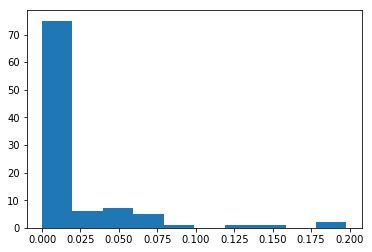

In [52]:
btwn_centrality_dict = nx.betweenness_centrality(G_109)

btwn_centrality_list = []
for vertex in btwn_centrality_dict:
    btwn_centrality_list.append(btwn_centrality_dict[vertex])



plt.hist(btwn_centrality_list)
plt.show()

In [63]:
graphs_modularity5 = []
graphs_maxbtwncentrality = []
max_btwncentrality_list = [0.2, 0.18, 0.15, 0.08, 0.07, 0.06, 0.05]

G_trimmed_new = G_109
for max_btwncentrality in max_btwncentrality_list:
    Gtrim_mod = btwncentralitytrim_max(G_trimmed_new, max_btwncentrality)
    G_trimmed_new = Gtrim_mod.G
    graphs_maxbtwncentrality.append(max_btwncentrality)
    graphs_modularity5.append(Gtrim_mod.mod) 

print (graphs_modularity5)
print (graphs_maxbtwncentrality)

[0.6730294672666571, 0.7290880740405411, 0.7367455621301775, 0.7641427035743079, 0.7641427035743079, 0.7641427035743079, 0.7641427035743079]
[0.2, 0.18, 0.15, 0.08, 0.07, 0.06, 0.05]


In [64]:
graphs_modularity6 = []
graphs_minbtwncentrality = []
min_btwncentrality_list = [0.001, 0.0015, 0.002, 0.003, 0.004]

G_trimmed_new = G_raw
for min_btwncentrality in min_btwncentrality_list:
    Gtrim_mod = btwncentralitytrim_min(G_trimmed_new, min_btwncentrality)
    G_trimmed_new = Gtrim_mod.G
    graphs_minbtwncentrality.append(min_btwncentrality)
    graphs_modularity6.append(Gtrim_mod.mod) 

print (graphs_modularity6)
print (graphs_minbtwncentrality)

[0.6549167533818937, 0.5978125, 0.5618512110726643, 0.5449999999999999, 0.5392390011890607]
[0.001, 0.0015, 0.002, 0.003, 0.004]


<Figure size 432x288 with 0 Axes>

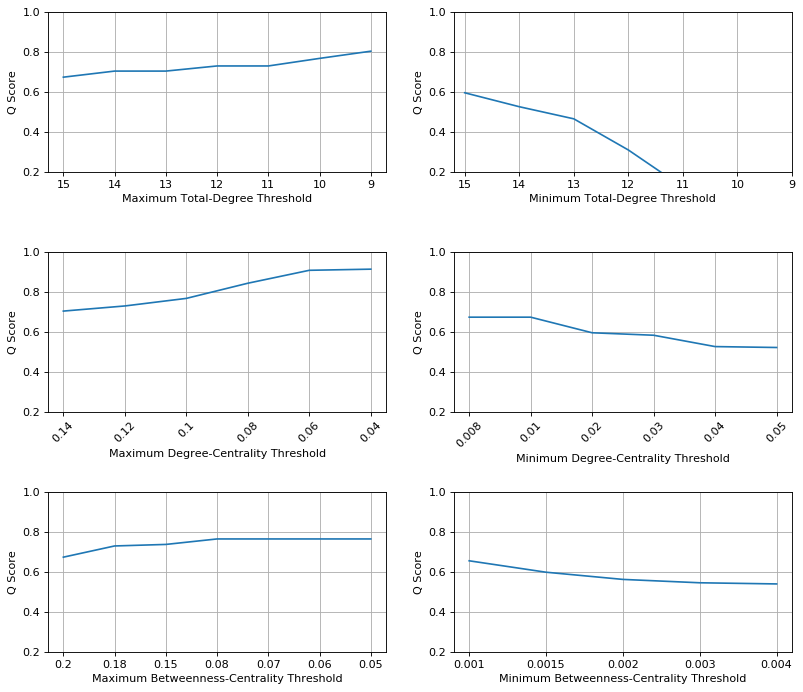

In [69]:
fig = plt.figure()
#fig.tight_layout()
plt.figure(figsize=(12, 10), dpi=80)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


plt.subplot(3, 2, 1)
plt.plot(graphs_modularity1)
plt.xticks(np.arange(len(graphs_maxdeg)), graphs_maxdeg)
plt.ylabel('Q Score')
plt.xlabel('Maximum Total-Degree Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))

plt.subplot(3, 2, 2)
plt.plot(graphs_modularity2)
plt.xticks(np.arange(len(graphs_maxdeg)), graphs_maxdeg)
plt.ylabel('Q Score')
plt.xlabel('Minimum Total-Degree Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))


plt.subplot(3, 2, 3)
plt.plot(graphs_modularity3)
plt.xticks(np.arange(len(graphs_maxdegcentrality)), graphs_maxdegcentrality, rotation=45)
plt.ylabel('Q Score')
plt.xlabel('Maximum Degree-Centrality Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))

plt.subplot(3, 2, 4)
plt.plot(graphs_modularity4)
plt.xticks(np.arange(len(graphs_mindegcentarlity)), graphs_mindegcentarlity, rotation=45)
plt.ylabel('Q Score')
plt.xlabel('Minimum Degree-Centrality Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))

plt.subplot(3, 2, 5)
plt.plot(graphs_modularity5)
plt.xticks(np.arange(len(graphs_maxbtwncentrality)), graphs_maxbtwncentrality)
plt.ylabel('Q Score')
plt.xlabel('Maximum Betweenness-Centrality Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))

plt.subplot(3, 2, 6)
plt.plot(graphs_modularity6)
plt.xticks(np.arange(len(graphs_minbtwncentrality)), graphs_minbtwncentrality)
plt.ylabel('Q Score')
plt.xlabel('Minimum Betweenness-Centrality Threshold')
plt.grid(True)
plt.ylim((0.20,1.00))


plt.show()

In [ ]:
def edgetrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G) 
    for edge in G.edges():
        if G.edges[edge]['weight'] >= max_threshold:
            tmpG.remove_edge(edge[0], edge[1])

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def edgetrim_min(G, min_threshold):
    tmpG = copy.deepcopy(G) 
    for edge in G.edges():
        if G.edges[edge]['weight'] <= min_threshold:
            tmpG.remove_edge(edge[0], edge[1]

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result